# IMPORTS

In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt
from darts import TimeSeries
from statsmodels.tsa.arima.model import ARIMA
from darts.metrics import mse
import warnings
from sklearn.metrics import mean_squared_error

warnings.filterwarnings("ignore", module='statsmodels')


/Users/cgalbeaza/Personal/Facultate/Licenta/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


# Utils

In [2]:
def load_data(ticker="^GSPC", start_date='1990-01-02', end_date='2024-03-20', split_date='2023-01-01', apply_filter=False, debug=False):
    """ Load data, perform forward fill, optionally apply a Butterworth filter, and split into train and test. """
    # Download historical data from Yahoo Finance
    df = yf.download(ticker, start=start_date, end=end_date)['Close']
    
    # Fill missing values and ensure all business days are accounted for
    all_business_days = pd.date_range(start=start_date, end=end_date, freq='B')
    df = df.reindex(all_business_days).ffill()  # Forward filling the missing values
    if apply_filter:
        df = apply_butterworth_filter(df, debug=debug)

    if debug:
        print(f"Data loaded and forward filled. Total rows after forward fill: {len(df)}.")

    # Split the data into train and test sets
    split_point = pd.Timestamp(split_date)
    train_series = df[df.index < split_point]
    test_series = df[df.index >= split_point]
    return train_series, test_series

def apply_butterworth_filter(series, order=3, critical_frequency=0.05, debug=False):
    """ Applies a zero-phase Butterworth filter to a given pandas Series. """
    b, a = butter(order, critical_frequency, btype='low', analog=False)
    filtered_values = filtfilt(b, a, series)
    filtered_series = pd.Series(filtered_values, index=series.index)
    if debug:
        print("✅ Zero-phase Butterworth filter applied.")
    return filtered_series

def train_arima(train_series, order=(1, 1, 1)):
    """ Train an ARIMA model on the provided training data. """
    model = ARIMA(train_series, order=order)
    results = model.fit()
    return results

def generate_predictions(model, start, end):
    """ Generate predictions using the trained ARIMA model. """
    predictions = model.predict(start=start, end=end, typ='levels')
    return predictions

def plot_predictions(test_series, prediction, title=""):
    plt.figure(figsize=(12, 6))
    plt.plot(test_series.index, test_series, label='Test')
    plt.plot(prediction.index, prediction, label='Prediction')
    plt.title(title)
    plt.legend()
    plt.show()

def plot_full_series(train_series, test_series, prediction, title=""):
    """ Plot the training data, test data, and ARIMA predictions. """
    plt.figure(figsize=(12, 6))
    plt.plot(train_series.index, train_series, label='Train')
    plt.plot(test_series.index, test_series, label='Test')
    plt.plot(prediction.index, prediction, label='Prediction')
    plt.title(title)
    plt.legend()
    plt.show()

[*********************100%%**********************]  1 of 1 completed


✅ Zero-phase Butterworth filter applied.
Data loaded and forward filled. Total rows after forward fill: 8927.
MSE: 171398.45583569945


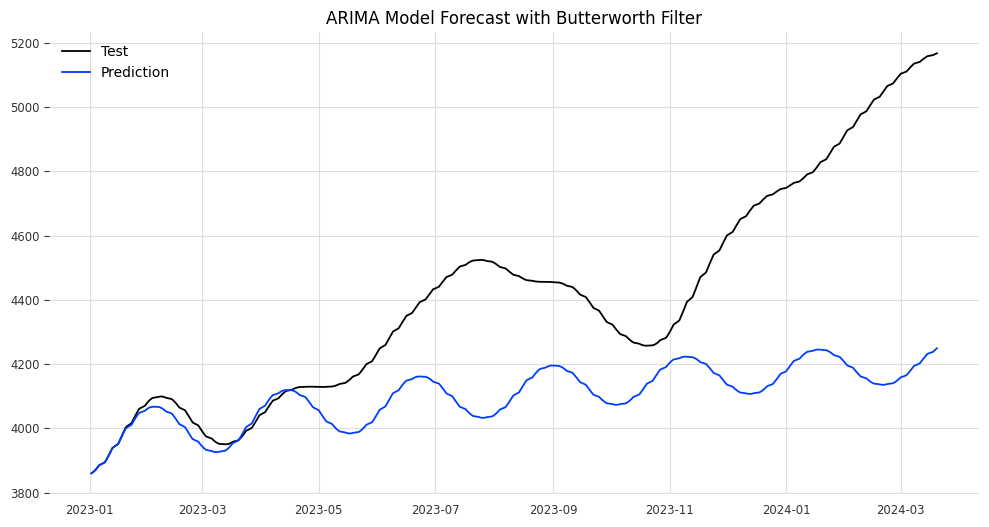

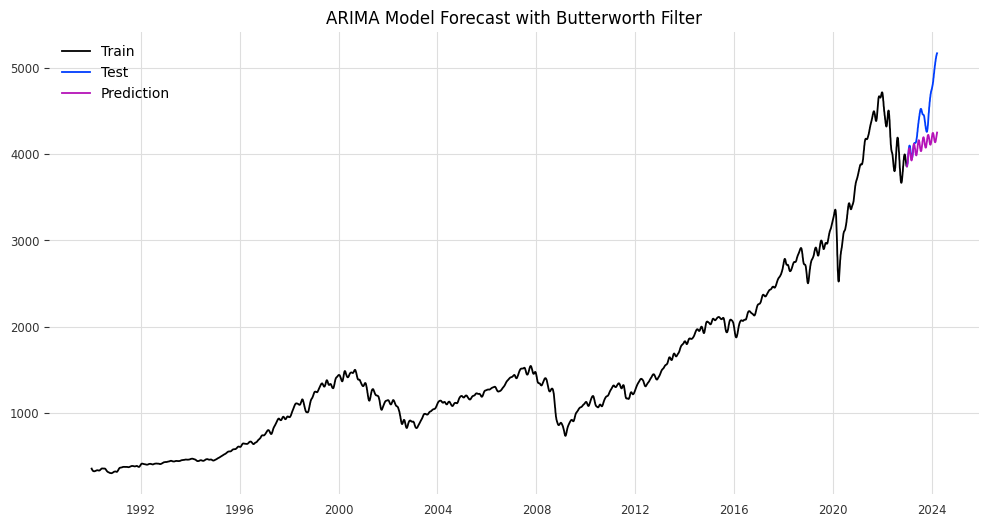

In [4]:
train_series, test_series = load_data(split_date="2023-01-01", apply_filter=True, debug=True)
model = train_arima(train_series, order=(3,1,0))
predictions = generate_predictions(model, start=test_series.index[0], end=test_series.index[-1])

error = mean_squared_error(test_series, predictions)
print(f"MSE: {error}")
plot_predictions(test_series, predictions, title="ARIMA Model Forecast with Butterworth Filter")
plot_full_series(train_series, test_series, predictions, title="ARIMA Model Forecast with Butterworth Filter")
